# Vehicle Detection

### Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

%matplotlib inline

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm
from scipy.ndimage.measurements import label

## Classifier

### Helper Functions

In [2]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    hist_features = np.histogram(img, bins=nbins, range=bins_range)
    #channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    #channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    #hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features[0]


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to return HOG features and visualization
def get_hog_features(img, orient = 9, pix_per_cell = 8, cell_per_block = 2, feature_vec=True):

    return hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
               cells_per_block=(cell_per_block, cell_per_block), visualise=False, feature_vector=feature_vec,
               block_norm="L2-Hys")


def calculateFeatures(img):
    
    features = []
    b, g, r = cv2.split(img)
    h, l, s = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2HLS))
    y, cr, cb = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb))
    
    features.append(bin_spatial(img))
    
    features.append(color_hist(h))
    #features.append(color_hist(s))
    #features.append(color_hist(y))
    features.append(color_hist(cr))
    features.append(color_hist(cb))
    
    #features.append(get_hog_features(h))
    features.append(get_hog_features(s))
    features.append(get_hog_features(y))
    #features.append(get_hog_features(b))
    #features.append(get_hog_features(g))
    #features.append(get_hog_features(r))
    
    return np.concatenate(features)



### Create Classifier

In [3]:
vehicles = glob.glob('data/vehicles/*/*.png')
non_vehicles = glob.glob('data/non-vehicles/*/*.png')

car_features = []
non_car_features = []
for car in vehicles:
    img = cv2.imread(car)
    car_features.append(calculateFeatures(img))
for nocar in non_vehicles:
    img = cv2.imread(nocar)
    non_car_features.append(calculateFeatures(img))

# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

clf = svm.SVC()
clf.fit(X_train, y_train)

score = clf.score(X_test, y_test)
print(score)

0.9887387387387387


## Pipeline

### Helper Functions

In [21]:
def search_image(img, clf, X_scaler, ystart = 380, ystop = 620, cells_per_step = 2, scale = 1):
    
    resized = img[ystart:ystop,:,:]
    
    if scale != 1:
        imshape = resized.shape
        resized = cv2.resize(resized, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    b, g, r = cv2.split(resized)
    h, l, s = cv2.split(cv2.cvtColor(resized, cv2.COLOR_BGR2HLS))
    y, cr, cb = cv2.split(cv2.cvtColor(resized, cv2.COLOR_BGR2YCrCb))

    he, wi = resized.shape[:2]
    pix_per_cell = 8
    cell_per_block = 2
    
    #blocks and steps as above
    nxblocks = (wi // pix_per_cell) - cell_per_block + 1
    nyblocks = (he // pix_per_cell) - cell_per_block + 1 
        
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hogs = []
    #hogs.append(get_hog_features(h, feature_vec=False))
    hogs.append(get_hog_features(s, feature_vec=False))
    hogs.append(get_hog_features(y, feature_vec=False))
    #hogs.append(get_hog_features(b, feature_vec=False))
    #hogs.append(get_hog_features(g, feature_vec=False))
    #hogs.append(get_hog_features(r, feature_vec=False))
    
    windows = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract features for this patch
            xleft = xpos * pix_per_cell
            ytop = ypos  * pix_per_cell
            
            features = []
            
            subimg = resized[ytop:ytop+window, xleft:xleft+window]
            features.append(bin_spatial(subimg))
            
            subh = h[ytop:ytop+window, xleft:xleft+window]
            #subs = cv2.resize(s[ytop:ytop+window, xleft:xleft+window], (64,64))
            #suby = cv2.resize(y[ytop:ytop+window, xleft:xleft+window], (64,64))
            subcr = cr[ytop:ytop+window, xleft:xleft+window]
            subcb = cb[ytop:ytop+window, xleft:xleft+window]
            
            features.append(color_hist(subh))
            #features.append(color_hist(subs))
            #features.append(color_hist(suby))
            features.append(color_hist(subcr))
            features.append(color_hist(subcb))
            
            for hog in hogs:
                features.append(hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel())

            feature = np.concatenate(features)



            # Scale features and make a prediction
            scaled = X_scaler.transform(feature.reshape(1, -1))    
            prediction = clf.predict(scaled)
            
            if prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                p1 = (xbox_left, ytop_draw + ystart)
                p2 = (xbox_left + win_draw, ytop_draw + win_draw + ystart)
                windows.append((p1, p2))
                
    return windows


def create_heatMap(img, clf, X_scaler, threshold = 2):
    windows = search_image(img, clf, X_scaler, scale = 1.8, cells_per_step = 4)
    windows += search_image(img, clf, X_scaler, scale = 1.5, cells_per_step = 3)
    windows += search_image(img, clf, X_scaler, scale = 1.2, cells_per_step = 2)
    
    heatmap = np.zeros(img.shape[:2], dtype = np.uint8)
    for w in windows:
        heatmap[w[0][1]:w[1][1], w[0][0]:w[1][0]] += 1
        
    heatmap[heatmap <= threshold] = 0
    
    return heatmap

def draw_labeled_bboxes(img, heatmap, color = (255, 0, 0)):
    labels = label(heatmap)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1] + 1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, 4)
    # Return the image
    return img

### Pipeline

In [8]:
from Lanes import pipeline as lanepipe

def pipeline(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    hm = create_heatMap(img, clf, X_scaler)
    return cv2.cvtColor(draw_labeled_bboxes(img, hm), cv2.COLOR_BGR2RGB)

def pipeline_with_lanes(img):
    bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    hm = create_heatMap(bgr, clf, X_scaler)
    lanes = lanepipe(img)
    return draw_labeled_bboxes(lanes, hm, (0, 0, 255))

### Playground

In [6]:


#plt.figure(figsize=(20,20))
#plt.subplot(1, 2, 1)
#plt.imshow(car)
#plt.subplot(1, 2, 2)
#plt.imshow(noc)

12.56 Seconds to detect Cars... test_images\test1.jpg
12.52 Seconds to detect Cars... test_images\test2.jpg
12.55 Seconds to detect Cars... test_images\test3.jpg
12.52 Seconds to detect Cars... test_images\test4.jpg
12.49 Seconds to detect Cars... test_images\test5.jpg
12.43 Seconds to detect Cars... test_images\test6.jpg


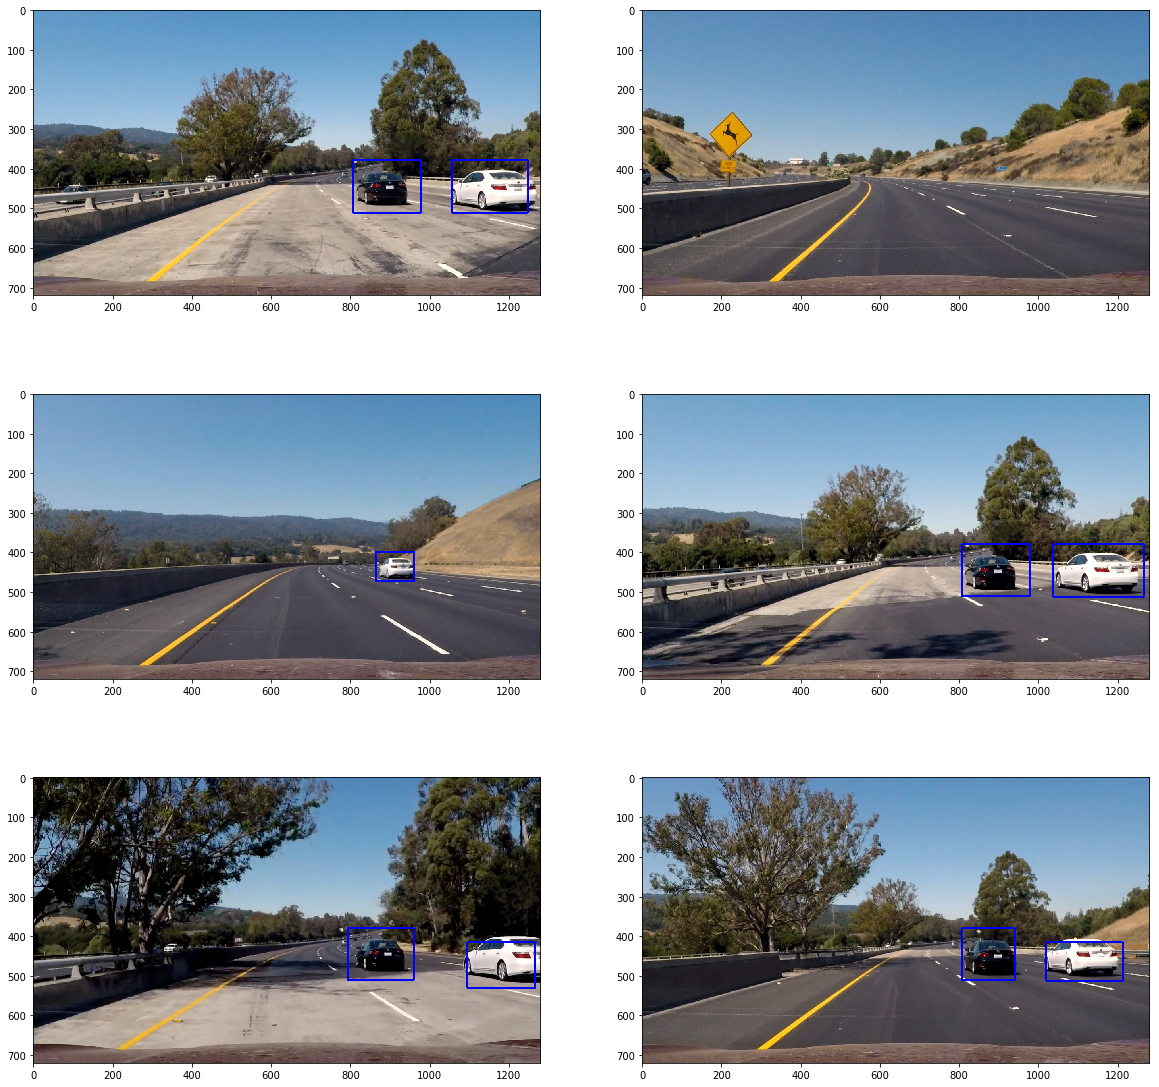

In [22]:
import time
tests = glob.glob('test_images/*.jpg')
plt.figure(figsize=(20,20))
i = 1
for test in tests:
    img = cv2.imread(test)
    t = time.time()
    hm = create_heatMap(img, clf, X_scaler)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to detect Cars...', test)
    nimg = cv2.cvtColor(draw_labeled_bboxes(img, hm), cv2.COLOR_BGR2RGB)
    plt.subplot(3, 2, i)
    plt.imshow(nimg)
    i = i + 1

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [24]:
output = 'output_images/project_video.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1260/1261 [4:25:51<00:12, 12.58s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

Wall time: 4h 25min 51s


In [25]:
from Lanes import State

state = State()
output = 'output_images/project_video_lanes.mp4'

clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_with_lanes) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

NameError: name 'state' is not defined